# Bike Sharing Demand: An EDA of Count Data

## 1. Project Goal
The objective of this project is to perform an Exploratory Data Analysis on the hourly bike sharing dataset from Washington D.C. The primary goal is to understand the key factors that influence the demand for rental bikes.

This analysis will focus on:
*   The unique characteristics of count data as a target variable (`cnt`).
*   The powerful influence of temporal patterns (hourly, daily, and seasonal).
*   The impact of weather conditions on rider behavior.
*   Building a narrative that could inform a demand forecasting model.

## 2. The Dataset
The dataset contains hourly rental data for a two-year period (2011-2012) and includes information on weather and seasonal factors.

*   **Source:** [Capital Bikeshare data from the UCI Machine Learning Repository, via Kaggle](https://www.kaggle.com/datasets/marklvl/bike-sharing-dataset?select=hour.csv)

### Data Dictionary (Key Columns)
*   **dteday:** The date of the observation.
*   **season:** Season of the year (1:spring, 2:summer, 3:fall, 4:winter).
*   **hr:** The hour of the day (0-23).
*   **holiday:** Whether the day is a holiday or not (1/0).
*   **weekday:** The day of the week (0-6).
*   **workingday:** If the day is neither a weekend nor holiday (1/0).
*   **weathersit:** Weather situation (1:Clear, 2:Mist, 3:Light Snow/Rain, 4:Heavy Rain/Snow).
*   **temp:** Normalized temperature in Celsius.
*   **atemp:** Normalized "feels like" temperature in Celsius.
*   **hum:** Normalized humidity.
*   **windspeed:** Normalized wind speed.
*   **casual:** Count of casual users.
*   **registered:** Count of registered users.
*   **cnt:** Total count of rental bikes including both casual and registered. This is our **target variable**.

In [3]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# --- Custom Utility Functions ---
# Add utility folder to python path
sys.path.append('../utils')  # Adjust path as needed
import eda_utils

# --- 2. LOAD DATA ---
file_path = './data/hour.csv'

# Important: Use 'parse_dates' to automatically convert the date column during loading
df = pd.read_csv(file_path, parse_dates=['dteday'])


# --- 3. INITIAL EXPLORATION ---
# Let's run our initial report
eda_utils.initial_report(df)

--- Initial Data Report ---

--- Shape ---
Rows: 17379, Columns: 17

--- Data Types & Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      

## 2. Data Cleaning and Feature Engineering

The initial report shows a well-structured dataset, but several important preparation steps are required to make it suitable for a deep temporal analysis. Our plan is as follows:

1.  **Drop Redundant Columns:** Remove columns that are either identifiers (`instant`) or highly correlated/redundant (`atemp`). We will also drop `casual` and `registered` for our main analysis of the total count (`cnt`) to avoid data leakage.
2.  **Map Categorical Variables:** The core categorical features (`season`, `yr`, `weekday`, `weathersit`) are currently stored as numerical codes. We will map these codes to their actual string labels (e.g., `1` -> `'spring'`) to make our plots and analysis far more intuitive and readable.
3.  **Correct Data Types:** Ensure all categorical features, including `hr`, `mnth`, `holiday`, etc., are converted to a `category` or `object` dtype so they are treated correctly by plotting libraries.
4.  **Feature Engineering (from `dteday`):** While the basic time features exist, we can create more. For example, we could extract the `year_month` to easily plot trends over time.

Let's begin.

In [4]:
# --- 1. Create the primary working DataFrame for analyzing total count ('cnt') ---
# We drop redundant columns AND the leakage columns ('casual', 'registered').
df_main = df.drop(columns=['instant', 'atemp', 'casual', 'registered'])


# --- 2. Map Categorical Codes to Meaningful Names ---
# Define the mappings
season_map = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
yr_map = {0: 2011, 1: 2012}
weekday_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
weathersit_map = {1: 'Clear', 2: 'Mist', 3: 'Light Snow/Rain', 4: 'Heavy Rain/Snow'}

# Apply the mappings to the new DataFrame
df_main['season'] = df['season'].map(season_map)
df_main['yr'] = df['yr'].map(yr_map)
df_main['weekday'] = df['weekday'].map(weekday_map)
df_main['weathersit'] = df['weathersit'].map(weathersit_map)


# --- 3. Correct Remaining Data Types ---
# Convert these columns to the 'category' dtype for efficiency
cols_to_cat = ['hr', 'mnth', 'holiday', 'workingday', 'season', 'yr', 'weekday', 'weathersit']
for col in cols_to_cat:
    df_main[col] = df_main[col].astype('category')


# --- 4. Final Verification of our MAIN DataFrame ---
print("--- Final Prepared DataFrame (df_main) ---")
df_main.info()
print("\n")
print(df_main.head())

--- Final Prepared DataFrame (df_main) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  category      
 2   yr          17379 non-null  category      
 3   mnth        17379 non-null  category      
 4   hr          17379 non-null  category      
 5   holiday     17379 non-null  category      
 6   weekday     17379 non-null  category      
 7   workingday  17379 non-null  category      
 8   weathersit  17379 non-null  category      
 9   temp        17379 non-null  float64       
 10  hum         17379 non-null  float64       
 11  windspeed   17379 non-null  float64       
 12  cnt         17379 non-null  int64         
dtypes: category(8), datetime64[ns](1), float64(3), int64(1)
memory usage: 817.0 KB


      dteday  season    yr mnth hr holiday

In [11]:
# --- Create a separate DataFrame for user type analysis ---
# Here, we keep 'casual' and 'registered' but drop 'cnt'.
df_users = df.drop(columns=['instant', 'atemp', 'cnt'])
# We can apply the same mappings to this DataFrame if we plan to analyze it.
df_users['season'] = df['season'].map(season_map)
df_users['yr'] = df['yr'].map(yr_map)
df_users['weekday'] = df['weekday'].map(weekday_map)
df_users['weathersit'] = df['weathersit'].map(weathersit_map)

## 3. Exploratory Data Analysis (EDA)

With our data cleaned, mapped, and correctly typed, we can now begin our exploration. This EDA will focus on understanding the patterns of bike rental demand, with a special focus on temporal (time-based) relationships.

Our analysis will explore:
1.  The distribution of our target variable, `cnt`.
2.  The overall trend of ridership over the two-year period.
3.  The powerful impact of hourly and daily patterns.
4.  The influence of seasons and weather conditions.

### 3.1 Analyzing the Target Variable: `cnt`

We'll start by examining the distribution of our target variable, the hourly bike rental count (`cnt`). This will help us understand the typical demand and its variability.

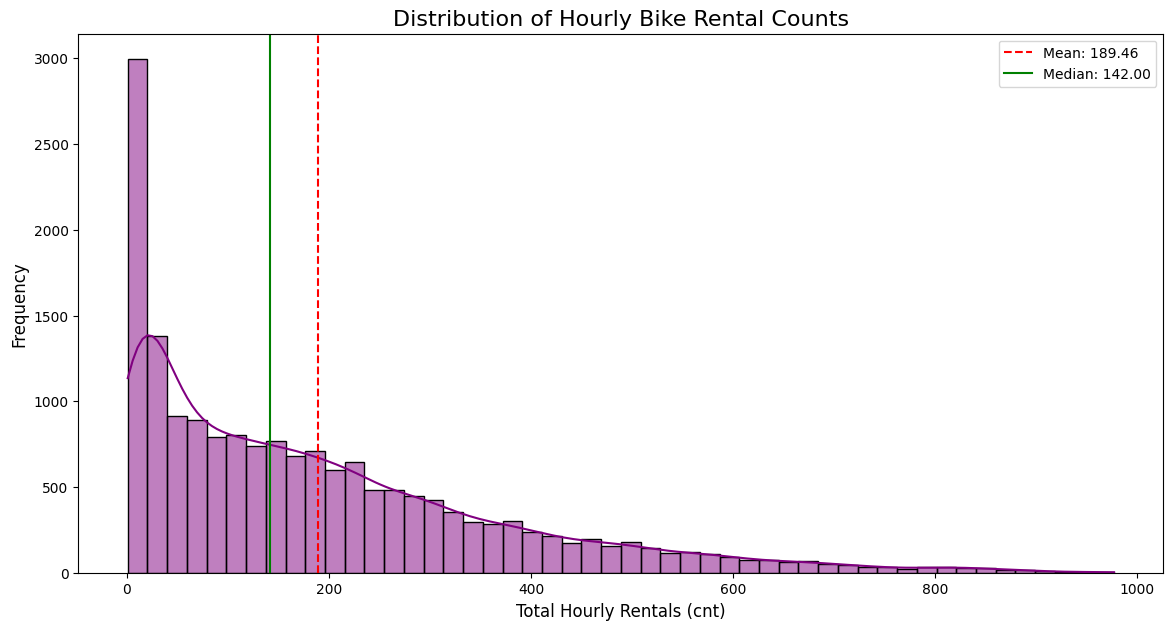

--- Target Variable Statistics ---
Mean Count: 189.46
Median Count: 142.00
Variance of Count: 32901.46
Ratio of Variance to Mean: 173.66


In [12]:
# --- Visualize the distribution of the hourly rental count ---

plt.figure(figsize=(14, 7))
sns.histplot(df_main['cnt'], bins=50, kde=True, color='purple')

# Add a title and labels
plt.title('Distribution of Hourly Bike Rental Counts', fontsize=16)
plt.xlabel('Total Hourly Rentals (cnt)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add lines for mean and median to highlight the skew
mean_cnt = df_main['cnt'].mean()
median_cnt = df_main['cnt'].median()
plt.axvline(mean_cnt, color='red', linestyle='--', label=f'Mean: {mean_cnt:.2f}')
plt.axvline(median_cnt, color='green', linestyle='-', label=f'Median: {median_cnt:.2f}')
plt.legend()

plt.show()

# --- Statistical Confirmation of Overdispersion ---
variance_cnt = df_main['cnt'].var()
print(f"--- Target Variable Statistics ---")
print(f"Mean Count: {mean_cnt:.2f}")
print(f"Median Count: {median_cnt:.2f}")
print(f"Variance of Count: {variance_cnt:.2f}")
print(f"Ratio of Variance to Mean: {variance_cnt/mean_cnt:.2f}")

**Observations on the Target Variable Distribution:**

1.  **Right-Skewed Distribution:** The histogram clearly shows that the distribution of hourly rental counts is heavily **positively skewed (right-skewed)**. The bulk of the data is concentrated at lower rental counts, with a long tail extending towards higher counts. This is confirmed by the **mean (189.46) being significantly greater than the median (142.00)**. This indicates that while the "typical" hour has 142 rentals, a number of very high-demand hours pull the average up.

2.  **Massive Overdispersion:** For a Poisson distribution, a key assumption is that the mean is approximately equal to the variance. Here, we observe:
    *   **Mean ≈ 189**
    *   **Variance ≈ 32,901**
    The variance is **~174 times larger than the mean**. This phenomenon is known as **overdispersion**.

**Implication for Modeling:**
The severe overdispersion confirms that a standard Poisson regression model would be a poor choice for this data, as it would severely underestimate the variance and lead to unreliable standard errors. This justifies the use of more flexible count models like the **Negative Binomial** or **Quasi-Poisson** regression, which are specifically designed to handle overdispersed data.

### 3.2 Overall Trend Analysis (Yearly and Monthly)

Now that we understand the hourly distribution, let's zoom out to look at the high-level trends. How did ridership evolve over the two-year period?

#### Ridership by Year
First, a simple comparison between the two years in the dataset.

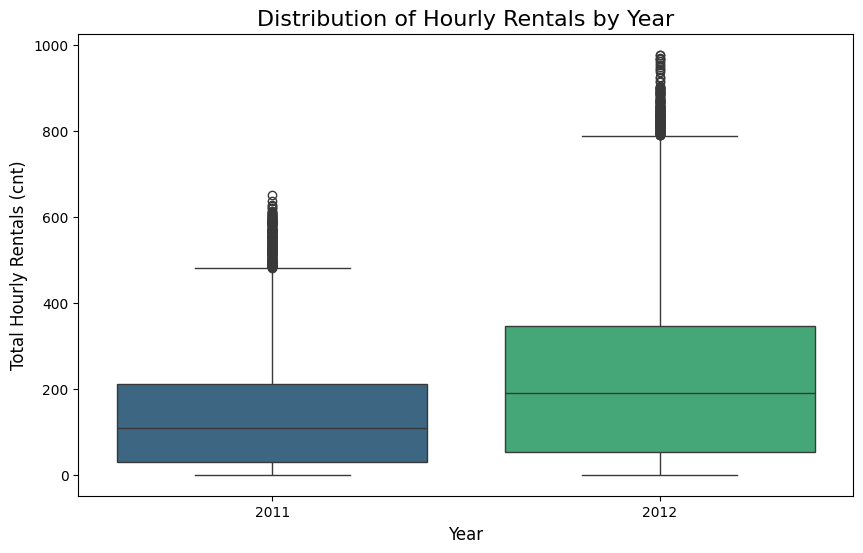

--- Total Rentals by Year ---
yr
2011    1243103
2012    2049576
Name: cnt, dtype: int64


In [13]:
# --- Compare total ridership by year ---
plt.figure(figsize=(10, 6))
# Boxplot is great for showing the distribution of hourly counts for each year
sns.boxplot(x='yr', y='cnt', hue='yr', data=df_main, legend = False, palette='viridis')
plt.title('Distribution of Hourly Rentals by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Hourly Rentals (cnt)', fontsize=12)
plt.show()

# Print the total counts for confirmation
print("--- Total Rentals by Year ---")
print(df_main.groupby('yr', observed=True)['cnt'].sum())

#### Monthly Ridership Trend Over Time

To see the trend and seasonality more clearly, let's plot the total monthly bike rentals across the entire two-year period. This will show both the year-over-year growth and the seasonal patterns.

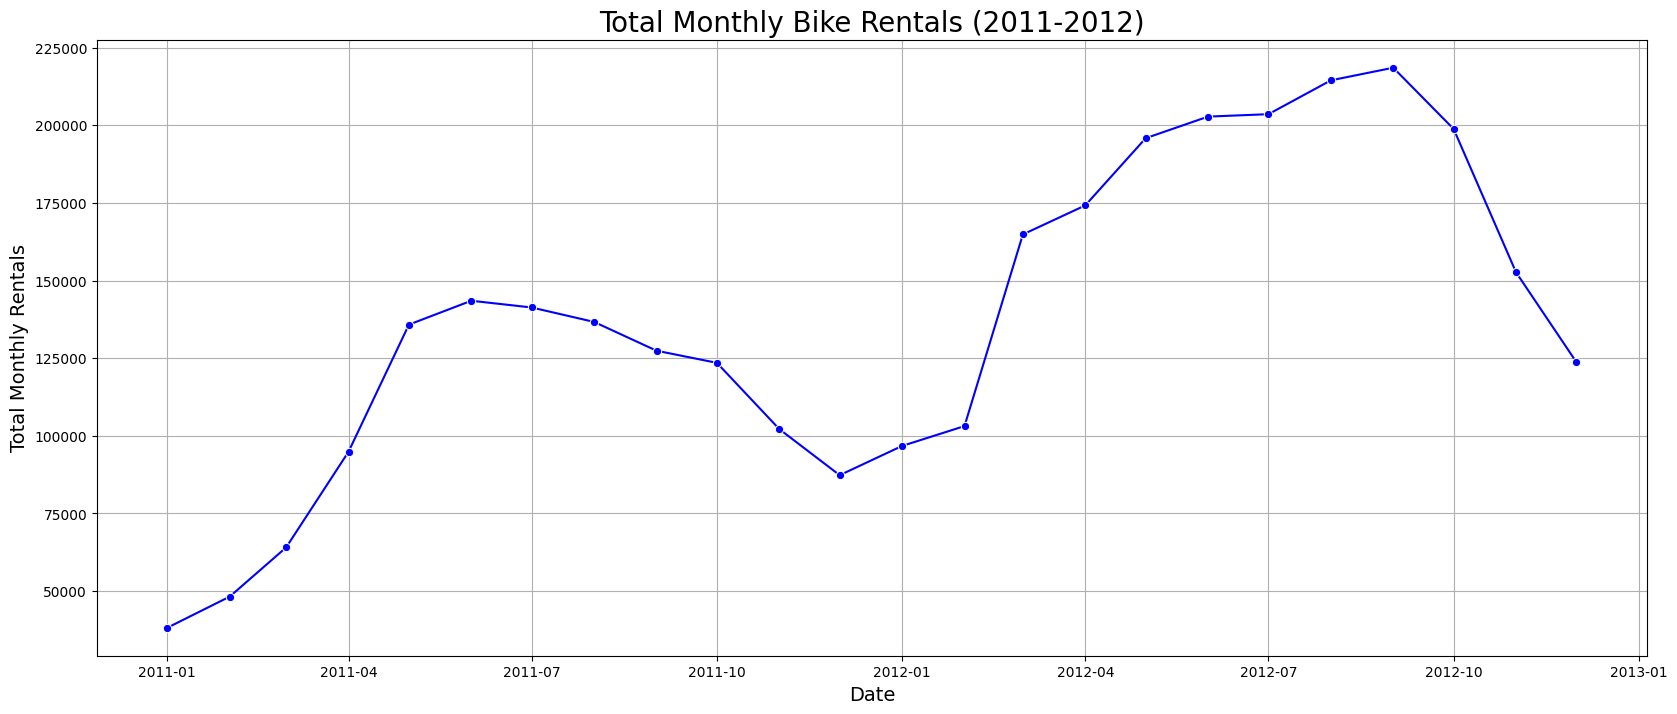

In [14]:
# --- Plot total monthly rentals over the two-year period ---

# We need to group by both year and month to get a time series
monthly_counts = df_main.groupby(['yr', 'mnth'], observed=True)['cnt'].sum().reset_index()

# To make a proper date for plotting, we'll create a 'year_month' column
# We need to make sure 'yr' and 'mnth' are treated as strings for concatenation
monthly_counts['year_month'] = pd.to_datetime(monthly_counts['yr'].astype(str) + '-' + monthly_counts['mnth'].astype(str))


plt.figure(figsize=(20, 8))
sns.lineplot(data=monthly_counts, x='year_month', y='cnt', marker='o', color='b')

plt.title('Total Monthly Bike Rentals (2011-2012)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Monthly Rentals', fontsize=14)
plt.grid(True)
plt.show()

**Observations from Yearly and Monthly Trends:**

1.  **Significant Year-Over-Year Growth:** The box plot and the total rental counts clearly show a massive increase in ridership from 2011 to 2012. The total number of rentals more than doubled, and the median hourly rental count also increased substantially. This indicates the bike sharing program was rapidly gaining popularity and adoption.

2.  **Strong and Predictable Seasonality:** The monthly line plot reveals a powerful seasonal pattern that repeats each year. Ridership is lowest in the winter months (Dec-Feb), begins to rise in the spring (Mar-May), peaks during the summer and early fall (Jun-Oct), and then declines again as winter approaches.

**Insight:**
The business is both **growing** and **seasonal**. This is a powerful combination. The growth suggests successful adoption, while the seasonality provides a predictable framework for operational planning. For example, maintenance schedules and bike redistribution efforts should be scaled up significantly in the summer and can be scaled down in the winter.

### 3.3 Intra-Day and Weekly Demand Patterns

The macro trends show growth and seasonality, but the most actionable insights for daily operations are found in the hourly and weekly patterns.

#### Average Hourly Demand

Let's analyze the average number of bike rentals for each hour of the day. This will reveal the daily pulse of the city's ridership.

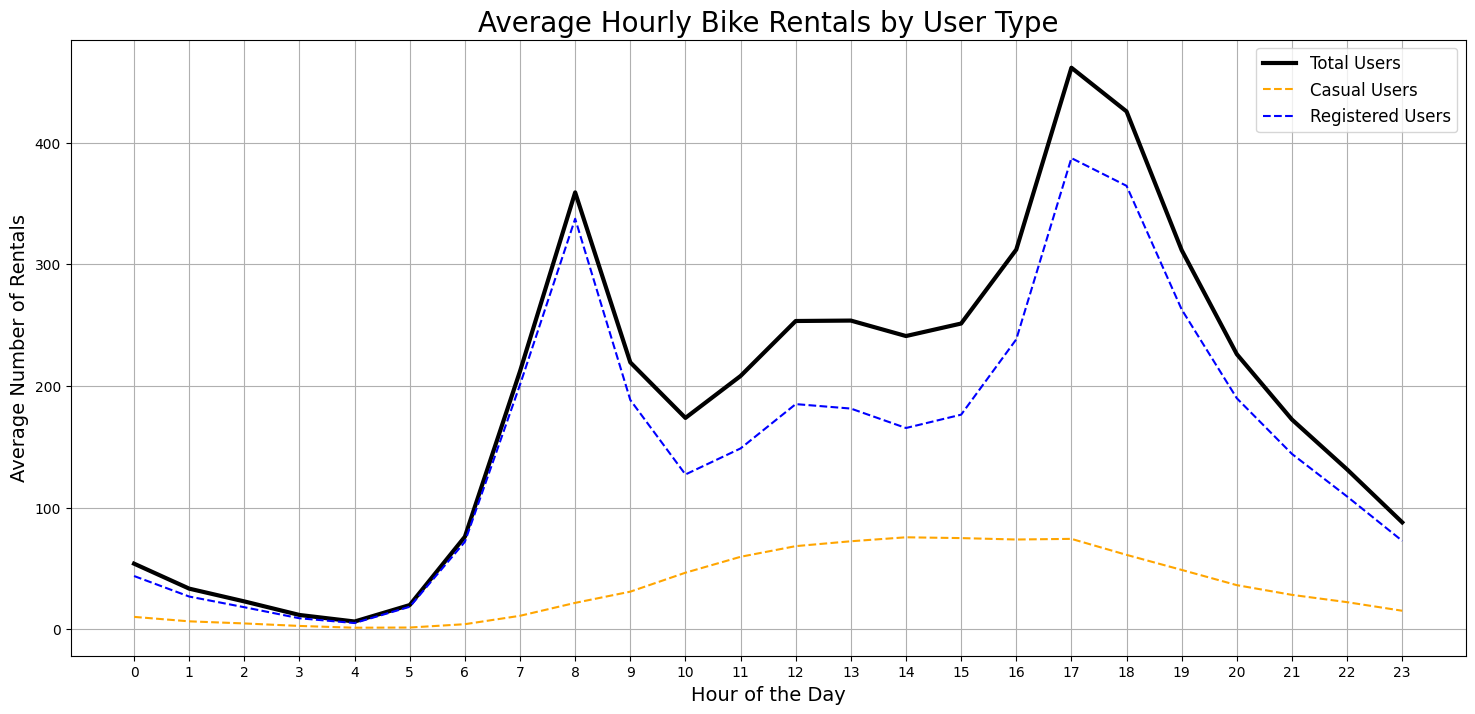

In [15]:
# --- Calculate average rentals per hour ---
# We use df_main for the total count
hourly_demand = df_main.groupby('hr', observed=True)['cnt'].mean()

# --- For the deeper story, let's analyze by user type from our df_users ---
# We need to make sure df_users has its 'hr' column as a category first.
df_users['hr'] = df_users['hr'].astype('category')
hourly_demand_users = df_users.groupby('hr', observed=True)[['casual', 'registered']].mean()


# --- Visualize the patterns ---
plt.figure(figsize=(18, 8))

# Plot the total demand
sns.lineplot(x=hourly_demand.index, y=hourly_demand.values, label='Total Users', color='black', linewidth=3)

# Plot the demand for casual users
sns.lineplot(x=hourly_demand_users.index, y=hourly_demand_users['casual'], label='Casual Users', color='orange', linestyle='--')

# Plot the demand for registered users
sns.lineplot(x=hourly_demand_users.index, y=hourly_demand_users['registered'], label='Registered Users', color='blue', linestyle='--')


plt.title('Average Hourly Bike Rentals by User Type', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Number of Rentals', fontsize=14)
plt.xticks(np.arange(0, 24, 1)) # Set x-axis ticks for every hour
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

**Observations on Hourly Demand:**

The hourly demand plot reveals a fascinating and bimodal (two-peaked) pattern, which is driven by two distinct user behaviors:

1.  **Registered Users (Commuters):** The blue dashed line shows two massive, sharp peaks at **8 AM** and again at **5-6 PM (17:00-18:00)**. These correspond perfectly with the morning and evening commute for working professionals. Demand is very low during midday and overnight. This is the classic "commuter" pattern.

2.  **Casual Users (Leisure/Tourists):** The orange dashed line tells a completely different story. Demand is low in the morning and begins to rise around 10 AM, forming a single, broad, bell-shaped peak in the afternoon from **12 PM to 5 PM (12:00-17:00)**. This is the classic "leisure" pattern of tourists or locals running errands or enjoying the afternoon.

3.  **Total Demand:** The black line shows that the overall demand is a **superposition of these two patterns**. The two sharp commuter peaks dominate the overall shape of the demand curve.

**Insight:**
The bike sharing service serves two fundamentally different customer segments with different needs. This insight is critical for operations:
*   Bike availability must be maximized in residential areas in the morning and in business districts in the evening to serve **commuters**.
*   Bike availability should be high around parks, tourist attractions, and commercial areas during the afternoon to serve **casual users**.
*   Marketing efforts could be tailored differently for these two groups (e.g., monthly passes for commuters, daily passes for tourists).

#### Weekly Demand Patterns: Weekday vs. Weekend

The hourly analysis revealed a strong commuter pattern. This leads to a natural hypothesis: **rental patterns on weekends should be significantly different from weekdays.** We expect to see lower overall demand but a different hourly profile, with the commuter peaks disappearing and the casual leisure peak becoming more dominant.

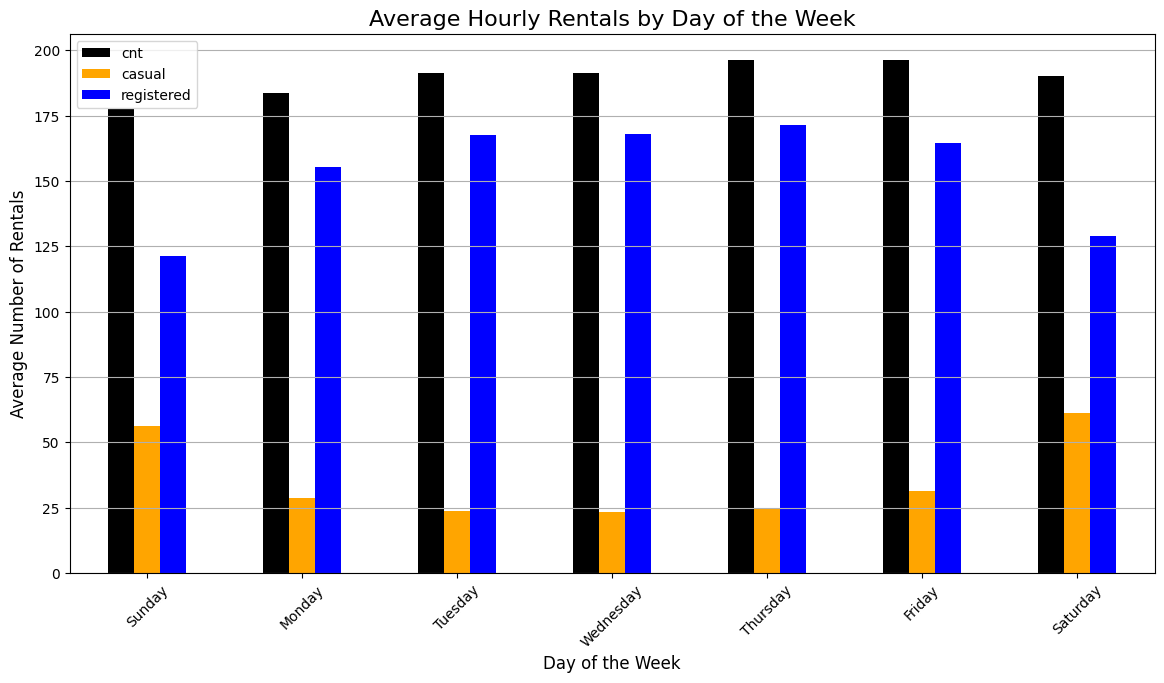

--- Average Rentals by Day of the Week ---
                  cnt     casual  registered
weekday                                     
Sunday     177.468825  56.163469  121.305356
Monday     183.744655  28.553449  155.191206
Tuesday    191.238891  23.580514  167.658377
Wednesday  191.130505  23.159192  167.971313
Thursday   196.436665  24.872521  171.564144
Friday     196.135907  31.458786  164.677121
Saturday   190.209793  61.246815  128.962978


In [16]:
# --- 1. Calculate average rentals by day of the week ---

# First, ensure 'weekday' is an ordered category in BOTH DataFrames so it plots correctly.
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Apply to df_main
df_main['weekday'] = pd.Categorical(df_main['weekday'], categories=weekday_order, ordered=True)

# We need to prep df_users as well for the user-type analysis
# (Ensure this cell is only run once or build a safety check)
if 'weekday' in df_users.columns and df_users['weekday'].dtype != 'category':
    df_users['weekday'] = pd.Categorical(df_users['weekday'], categories=weekday_order, ordered=True)


# --- Calculate aggregates from the correct DataFrames ---

# Get the total count from df_main
daily_demand_total = df_main.groupby('weekday', observed=True)['cnt'].mean()

# Get the user breakdown from df_users
daily_demand_users = df_users.groupby('weekday', observed=True)[['casual', 'registered']].mean()

# Combine them into one DataFrame for easy plotting and viewing
daily_demand_combined = pd.concat([daily_demand_total, daily_demand_users], axis=1)


# --- 2. Visualize average rentals by day of the week ---
# Now we plot from our newly combined DataFrame
daily_demand_combined.plot(kind='bar', figsize=(14, 7),
                           color={'casual': 'orange', 'registered': 'blue', 'cnt': 'black'})

plt.title('Average Hourly Rentals by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Number of Rentals', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Print the numbers from the combined table
print("--- Average Rentals by Day of the Week ---")
print(daily_demand_combined)

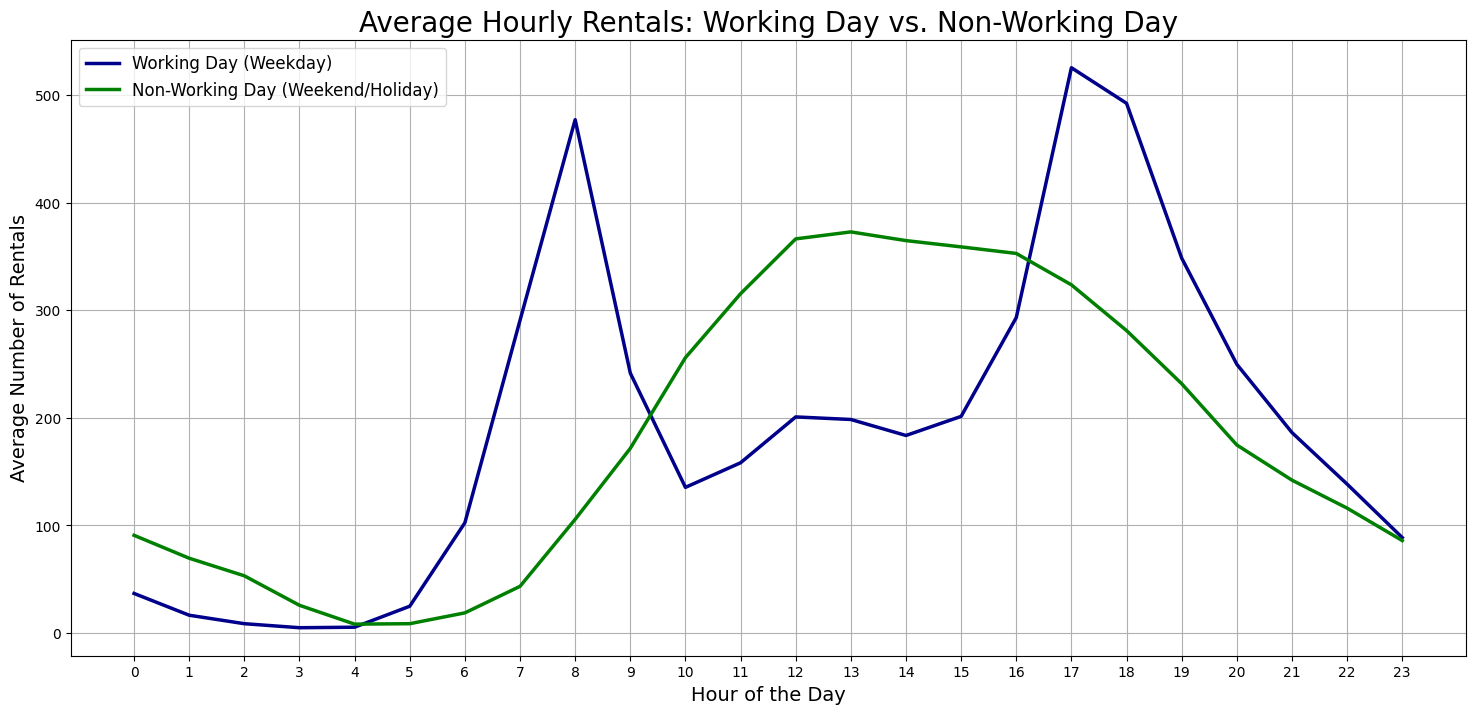

In [17]:
# --- 3. Compare hourly demand on working days vs. non-working days ---
hourly_demand_by_daytype = df_main.groupby(['workingday', 'hr'], observed=True)['cnt'].mean().unstack()

# --- Visualize the comparison ---
plt.figure(figsize=(18, 8))

# Plot for working days (0 = No, 1 = Yes)
sns.lineplot(data=hourly_demand_by_daytype.loc[1], label='Working Day (Weekday)', color='darkblue', linewidth=2.5)

# Plot for non-working days (weekends/holidays)
sns.lineplot(data=hourly_demand_by_daytype.loc[0], label='Non-Working Day (Weekend/Holiday)', color='green', linewidth=2.5)

plt.title('Average Hourly Rentals: Working Day vs. Non-Working Day', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Number of Rentals', fontsize=14)
plt.xticks(np.arange(0, 24, 1))
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

**Analysis of Weekly Patterns & Hypothesis Test:**

Our hypothesis was that average rentals would be higher on weekends. The data reveals a more nuanced and interesting story:

1.  **Overall Volume:** The bar chart shows that **total average daily rentals are actually slightly lower on weekends** compared to the peak midweek days (Wednesday-Friday). Our initial hypothesis is not supported in terms of total volume.

2.  **User Composition:** The key difference is the *type* of rider. On weekdays, `registered` users dominate, making up the vast majority of rides. On weekends, `casual` use explodes, nearly matching the volume of registered users.

3.  **Hourly Profile Transformation:** The final line plot provides the definitive answer.
    *   On **working days**, we see the sharp, bimodal **commuter peaks** at 8 AM and 5-6 PM.
    *   On **non-working days**, the commuter peaks completely disappear. They are replaced by a single, broad **leisure peak** that is very similar to the `casual` user profile we saw earlier, centered around 1-4 PM.

**Insight:**

The service functions as two separate businesses operating on different schedules:
*   **The "Commuter Utility" (Weekdays):** Dominated by registered users with sharp morning and evening peaks. This is a high-volume, predictable, transportation-focused business.
*   **The "Leisure Service" (Weekends):** Dominated by casual users with a broad afternoon peak. This is a recreational, experience-focused business.

This deep understanding of the customer base is critical. It implies that a "one-size-fits-all" operational strategy is suboptimal. The company needs to tailor its bike placement, marketing messages, and potentially its pricing (e.g., "Weekend Explorer Pass" vs. "Monthly Commuter Pass") to cater to these two very different use cases.

### 3.4 The Influence of External Factors: Weather and Season

The final part of our EDA is to understand how external, environmental factors impact bike rental demand. The most obvious factors are the season of the year and the daily weather conditions.

#### The Impact of Weather Situation

Our hypothesis is that ridership is highly sensitive to the weather. We expect to see a clear ordinal relationship: as the weather gets worse, the number of rentals will decrease. Let's visualize this relationship for all users, and then by user type.

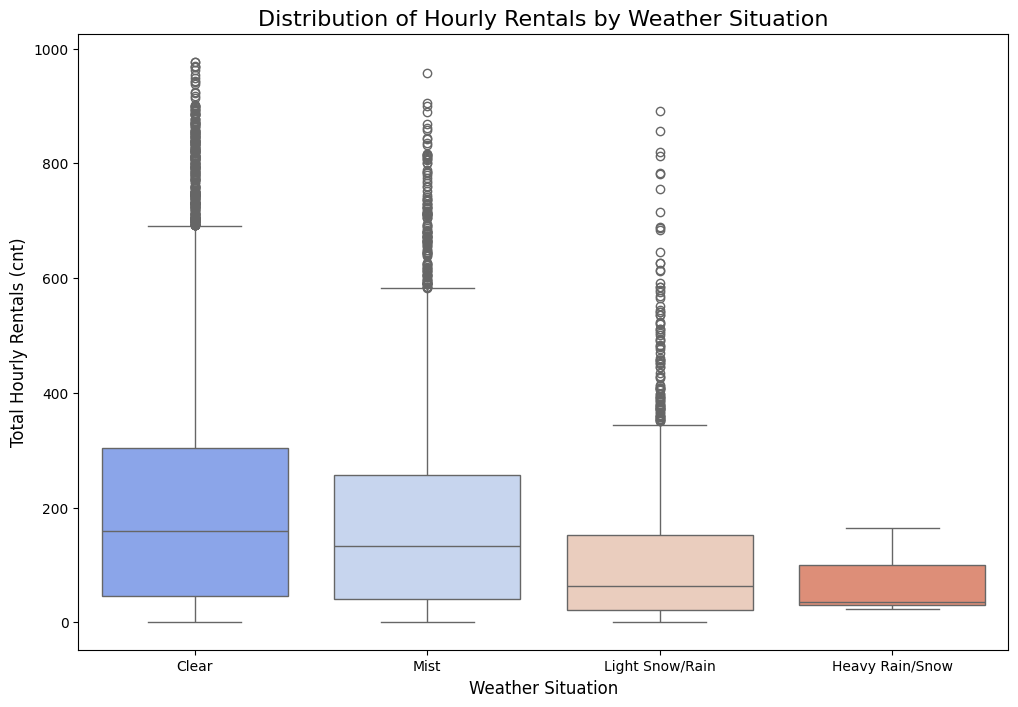

In [18]:
# --- 1. Set the correct order for the 'weathersit' category ---
weather_order = ['Clear', 'Mist', 'Light Snow/Rain', 'Heavy Rain/Snow']
df_main['weathersit'] = pd.Categorical(df_main['weathersit'], categories=weather_order, ordered=True)

# --- 2. Visualize the effect of weather on TOTAL rentals ---
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_main, x='weathersit', y='cnt',
            hue='weathersit', legend=False, palette='coolwarm')
plt.title('Distribution of Hourly Rentals by Weather Situation', fontsize=16)
plt.xlabel('Weather Situation', fontsize=12)
plt.ylabel('Total Hourly Rentals (cnt)', fontsize=12)
plt.show()

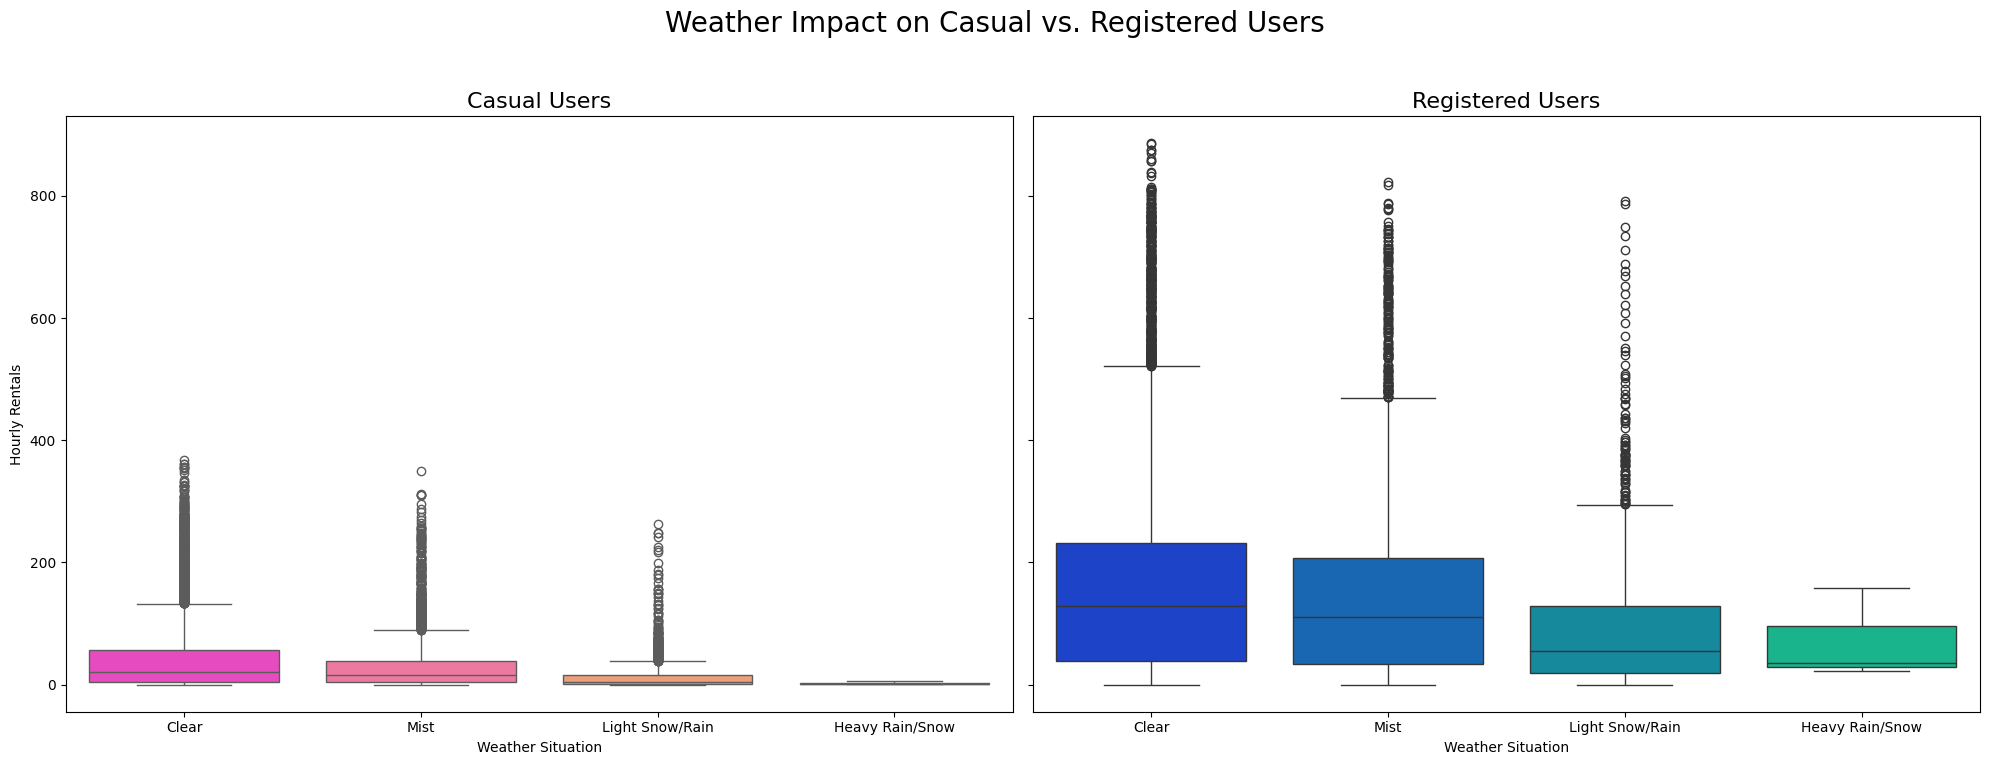

In [19]:
# --- 3. Drill down by user type (using df_users) ---
# First, apply the same categorical ordering to df_users
df_users['weathersit'] = pd.Categorical(df_users['weathersit'], categories=weather_order, ordered=True)

# Create a figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
fig.suptitle('Weather Impact on Casual vs. Registered Users', fontsize=20)

# Plot for Casual Users
sns.boxplot(data=df_users, x='weathersit', y='casual', ax=axes[0],
            hue='weathersit', legend=False, palette='spring')
axes[0].set_title('Casual Users', fontsize=16)
axes[0].set_xlabel('Weather Situation')
axes[0].set_ylabel('Hourly Rentals')

# Plot for Registered Users
sns.boxplot(data=df_users, x='weathersit', y='registered', ax=axes[1],
            hue='weathersit', legend=False, palette='winter')
axes[1].set_title('Registered Users', fontsize=16)
axes[1].set_xlabel('Weather Situation')
axes[1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observations on Weather's Impact:**

The data provides strong confirmation for our hypotheses:

1.  **Clear Ordinal Effect:** There is a powerful and predictable negative relationship between weather severity and bike rentals. The median hourly rentals are highest in 'Clear' weather, drop significantly in 'Mist', and fall even further during 'Light Snow/Rain'. The single data point for 'Heavy Rain/Snow' shows near-zero ridership, as expected.

2.  **Casual Users are More Weather-Sensitive:** The drill-down by user type confirms our second hypothesis. While both user types are affected by bad weather, the drop-off for **casual users is far more dramatic**. The median rental count for casual users plummets in 'Mist' and 'Light Snow/Rain'.

3.  **Commuter Resilience:** **Registered users**, while also preferring good weather, are more resilient. A significant number of commuters still ride during 'Mist' and 'Light Snow/Rain', likely because it is their primary mode of transportation. Their demand is less elastic to weather changes compared to the highly elastic demand of casual riders.

**Insight:**
Weather is a major short-term forecasting variable. Any demand prediction model would need to heavily weigh the weather forecast. Furthermore, this analysis confirms the "hardcore" nature of the commuter segment versus the "fair-weather" nature of the leisure segment, which could inform different marketing or communication strategies during inclement weather (e.g., "Don't let the rain stop you!" vs. "Come back when the sun is out!").

## 4. Executive Summary & Key Insights

This Exploratory Data Analysis of the hourly bike sharing data has successfully identified the core patterns that drive rental demand in Washington D.C. By analyzing temporal trends and the impact of external factors, we can construct a clear narrative of rider behavior.

### The Two Rider Personas:

The analysis revealed that the bike sharing service caters to two distinct customer segments with fundamentally different behaviors:

1.  **The "Commuter" (Registered Users):** This is the primary user base. Their behavior is highly predictable, with sharp demand peaks during morning (8 AM) and evening (5-6 PM) commute hours on weekdays. They are resilient to moderately bad weather and represent a stable, utility-focused demand.
2.  **The "Leisure Rider" (Casual Users):** This segment's behavior is driven by recreation and tourism. Their demand is highest during afternoons and explodes on weekends. They are highly sensitive to weather conditions and largely disappear during inclement weather.

### Key Drivers of Demand:

*   **Time of Day & Day of Week:** These are the most powerful predictors. The bimodal commuter peak on weekdays and the single leisure peak on weekends are the dominant patterns.
*   **Seasonality & Weather:** Demand follows a strong, predictable seasonal curve, peaking in summer/fall and bottoming out in winter. On a daily basis, clear weather is a major driver, with demand dropping sharply as conditions worsen.
*   **Long-Term Growth:** The service showed significant year-over-year growth from 2011 to 2012, indicating successful market adoption.

### Future Modeling & Strategic Recommendations:

The insights from this EDA provide a clear roadmap for building an accurate demand forecasting model and for making strategic operational decisions.

**Modeling Recommendations:**
*   **Target Variable:** The target variable, `cnt`, exhibits significant **overdispersion** (variance >> mean). A standard Poisson regression would be inappropriate. The ideal modeling approach would be a **Negative Binomial Regression** or a tree-based model like **XGBoost**, which can handle this property.
*   **Feature Engineering:** The most important features for a model would be cyclical representations of `hr` and `weekday` (e.g., using sine/cosine transformations), along with `weathersit`, `temp`, `hum`, and a variable for `yr` to capture the growth trend.
*   **Dual-Model Approach:** For maximum accuracy, it would be beneficial to build **two separate models**: one to predict `casual` demand and another for `registered` demand, and then sum their predictions. This would allow the model to learn the two distinct behavioral patterns we uncovered.

**Business Recommendations:**
*   **Dynamic Bike Placement:** Use the hourly demand patterns to dynamically redistribute bikes, ensuring high availability in residential areas during morning rush hour and in business/leisure districts during the evening and on weekend afternoons.
*   **Targeted Marketing:** Develop separate marketing campaigns and pricing strategies for the two personas (e.g., monthly commuter passes vs. weekend leisure packages).